In [1]:
from sympy import symbols, init_printing
init_printing()
from celmech.hamiltonian import AndoyerHamiltonian
from celmech.transformations import poincare_vars_to_andoyer_vars, poincare_vars_from_sim
from celmech.transformations import jacobi_masses_from_sim, get_scaled_andoyer_params

In [2]:
import rebound
import numpy as np

def make_sim(j, k):
    mass = 1.e-5
    e0 = 0.1 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, pomega = np.pi/2., P=1., theta=np.pi)
    sim.add(m=4*mass, e=1.e-5, P=j/float(j-k))
    sim.move_to_com()
    return sim

j=5
k=1
sim = make_sim(j,k)

In [3]:
from celmech.disturbing_function import laplace_coefficient
mjac, Mjac, mu = jacobi_masses_from_sim(sim)
pvars = poincare_vars_from_sim(sim)

In [4]:
'''
ps = sim.particles
s=0 
alpha = ps[1].a/ps[2].a
deltan = ps[1].n-ps[2].n
LambdaOut = pvars[4]
prefac = mu[2]/LambdaOut**2*mjac[1]/Mjac[1]/deltan
for j in range(1,150):
    s += laplace_coefficient(0.5, j, 0, alpha)*np.cos(j*(ps[1].l - ps[2].l))
s -= alpha*np.cos(ps[1].l - ps[2].l)
s *= prefac
pvars[0] -= s # update numerical value of Lambda
pvars[4] += s
'''

'\nps = sim.particles\ns=0 \nalpha = ps[1].a/ps[2].a\ndeltan = ps[1].n-ps[2].n\nLambdaOut = pvars[4]\nprefac = mu[2]/LambdaOut**2*mjac[1]/Mjac[1]/deltan\nfor j in range(1,150):\n    s += laplace_coefficient(0.5, j, 0, alpha)*np.cos(j*(ps[1].l - ps[2].l))\ns -= alpha*np.cos(ps[1].l - ps[2].l)\ns *= prefac\npvars[0] -= s # update numerical value of Lambda\npvars[4] += s\n'

In [5]:
sim = make_sim(j,k)
pvars = poincare_vars_from_sim(sim)
ps = sim.particles


Lambda10 = pvars[0]
Lambda20 = pvars[4]
n10 = ps[1].n
n20 = ps[2].n
ps = sim.particles


x = poincare_vars_to_andoyer_vars(pvars, sim.G, ps[0].m, mjac[1], mjac[2], j, k, Lambda10, Lambda20,actionscale=Lambda10)
Phi0, phi0, W0, w0, Brouwer0, K0, Acoeff, Bcoeff, Ccoeff = x
pscale, tscale, Phiprime = get_scaled_andoyer_params(Acoeff, Bcoeff, Ccoeff, k)

In [6]:
x

In [7]:
pscale, tscale, Phiprime

In [21]:
sim = make_sim(j,k)
pvars = poincare_vars_from_sim(sim)
ps = sim.particles


Lambda10 = pvars[0]
Lambda20 = pvars[4]
n10 = ps[1].n
n20 = ps[2].n
ps = sim.particles


x = poincare_vars_to_andoyer_vars(pvars, sim.G, ps[0].m, mjac[1], mjac[2], j, k, Lambda10=Lambda10, Lambda20=Lambda20)
print(x[0])
Phi0, phi0, W0, w0, Brouwer0, K0, Acoeff, Bcoeff, Ccoeff = x
pscale, tscale, Phiprime = get_scaled_andoyer_params(Acoeff, Bcoeff, Ccoeff, k)

Hsim = AndoyerHamiltonian(k, Phiprime, Phi0/pscale, phi0)

Norbits = 3000
Nout = 1000
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)
symtimes = times/abs(tscale)

Nsol = np.zeros((2, Nout))
symsol = np.zeros((2, Nout))
pratio, BrouwerErr, WErr, Ks = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)

for i, time in enumerate(times):
    pratio[i] = ps[2].P/ps[1].P
    pvars = poincare_vars_from_sim(sim)
    x = poincare_vars_to_andoyer_vars(pvars, sim.G, ps[0].m, mjac[1], mjac[2], j, k, Lambda10=Lambda10, Lambda20=Lambda20)
    Phi0, phi0, W, w, Brouwer, K, Acoeff, Bcoeff, Ccoeff = x
    BrouwerErr[i] = Brouwer #abs((Brouwer-Brouwer0)/Brouwer0)
    WErr[i] = W #abs((W-W0)/W0)
    Ks[i] = K


    symsol[:,i] = Hsim.integrator.y
    Nsol[:,i] = [Phi0/pscale, phi0]

    sim.integrate(np.sign(tscale)*time)    
    Hsim.integrate(symtimes[i])
    
 


BrouwerErr = (BrouwerErr - np.mean(BrouwerErr))/np.mean(BrouwerErr)
WErr=(WErr-np.mean(WErr))/np.mean(WErr)
#Ks = (K- np.mean(Ks))/np.mean(K)

2.44037136631e-07


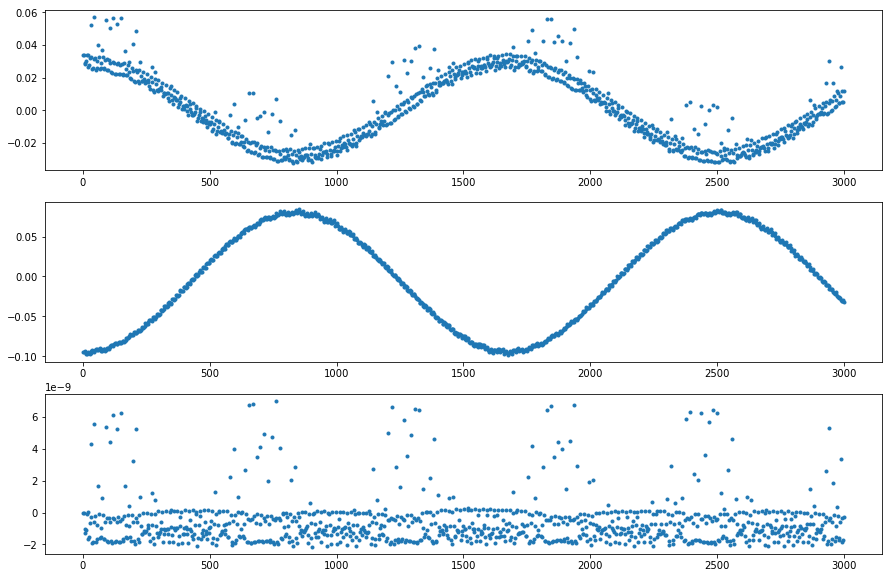

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(figsize=(15,10), nrows=3)
axarr[0].plot(times, BrouwerErr, '.')
axarr[1].plot(times, WErr, '.')
axarr[2].plot(times, Ks, '.')

In [24]:
tscale

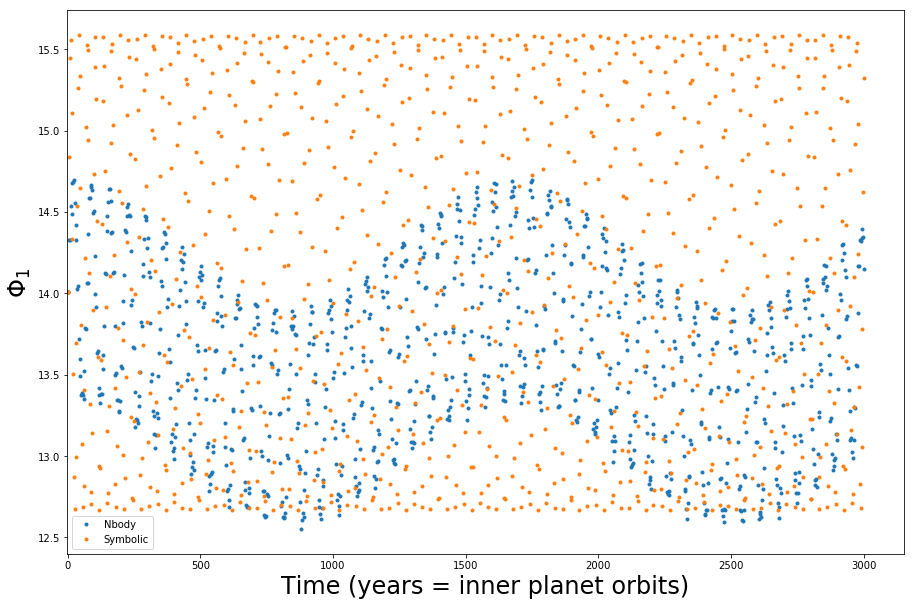

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Phi_1$", fontsize=24)

ax.plot(times, Nsol[0,:], '.', label='Nbody')
ax.plot(times, symsol[0,:], '.', label='Symbolic')

ax.legend()
ax.set_xlim(xmin=-3)

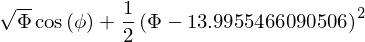

In [27]:
Hsim.NH

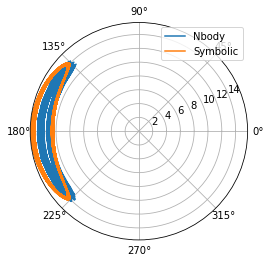

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.subplot('111', projection='polar')
ax.plot(Nsol[1,:], Nsol[0,:], label='Nbody')
ax.plot(symsol[1,:], symsol[0,:], label='Symbolic')
ax.legend()